In [1]:
import numpy as np
import xarray as xr
import cf_xarray
import neutralocean
import neutralocean.grid.rectilinear
import neutralocean.ntp

from xgcm import Grid
import gsw_xarray as gsw

import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset("../data/processed_woa.nc").transpose("x_c", "y_c", "z_c", ...)
ds

<xarray.Dataset> Size: 159MB
Dimensions:      (z_c: 102, y_c: 180, x_c: 360, x_f: 360, y_f: 180, z_f: 102)
Coordinates: (12/17)
    lat          (y_c) float32 720B ...
    depth        (z_c) float32 408B ...
    lon          (x_c) float32 1kB ...
    lon_right    (x_f) float32 1kB ...
    lat_right    (y_f) float32 720B ...
    depth_right  (z_f) float32 408B ...
    ...           ...
  * z_f          (z_f) int64 816B 0 1 2 3 4 5 6 7 ... 94 95 96 97 98 99 100 101
    e1tu         (y_c) float32 720B ...
    e2           float32 4B ...
    e1vf         (y_f) float32 720B ...
    e3w          (z_f) float32 408B ...
    e3t          (z_c) float32 408B ...
Data variables:
    t_an         (x_c, y_c, z_c) float32 26MB ...
    s_an         (x_c, y_c, z_c) float32 26MB ...
    p            (y_c, z_c) float64 147kB ...
    SA           (x_c, y_c, z_c) float64 53MB ...
    CT           (x_c, y_c, z_c) float64 53MB ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           World Ocean Atlas 2023 : sea_water_pract...
    summary:                         Climatological mean salinity for the glo...
    references:                      Reagan, J.R., D. Seidov, Z. Wang, D. Duk...
    institution:                     NOAA National Centers for Environmental ...
    comment:                         Global Climatology as part of the World ...
    ...                              ...
    ncei_template_version:           NCEI_NetCDF_Grid_Template_v1.0
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   https://www.ncei.noaa.gov/products/world...
    date_created:                    2024-01-28 
    date_modified:                   2024-01-28

In [3]:
grid = Grid(ds, periodic=["X"], metrics={"X":["e1tu","e1vf"], "Y":["e2"], "Z":["e3t","e3w"]})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x_c --> right
  * right    x_f --> center
Y Axis (not periodic, boundary=None):
  * center   y_c --> right
  * right    y_f --> center
Z Axis (not periodic, boundary=None):
  * center   z_c --> right
  * right    z_f --> center

In [4]:
ni, nj, nk = ds.cf["sea_water_conservative_temperature"].shape

In [5]:
ni, nj, nk

(360, 180, 102)

In [6]:
neutralocean_grid = neutralocean.grid.rectilinear.build_grid(
    dims=(ni, nj),
    periodic=(True, False),
    dxC=ds.e1tu,
    dyC=ds.e2,
    dxG=ds.e1vf,
    dyG=ds.e2
)

In [7]:
# easiest is to use a for loop to compute at every depth

In [8]:
%%time

ex_3d = np.zeros((ni,nj,nk))
ey_3d = np.zeros((ni,nj,nk))

for k in range(ds.depth.shape[0]):
    e = neutralocean.ntp.ntp_epsilon_errors(
        ds.isel(z_c=k).cf["sea_water_absolute_salinity"],
        ds.isel(z_c=k).cf["sea_water_conservative_temperature"],
        ds.isel(z_c=k)["depth"].broadcast_like(ds.isel(z_c=k).cf["sea_water_absolute_salinity"]),
        neutralocean_grid
    )
    # Convert e above into two 2D maps, one for zonal ϵ errors and one for meridional ϵ errors
    ex, ey = neutralocean.grid.rectilinear.edgedata_to_maps(e, (ni, nj), (True, False))
    ex_3d[:,:,k] = ex
    ey_3d[:,:,k] = ey

ds["ex_neutralocean"] = (["x_f", "y_c", "z_c"], ex_3d)
ds["ey_neutralocean"] = (["x_c", "y_f", "z_c"], ey_3d)

CPU times: user 10 s, sys: 206 ms, total: 10.2 s
Wall time: 10.2 s


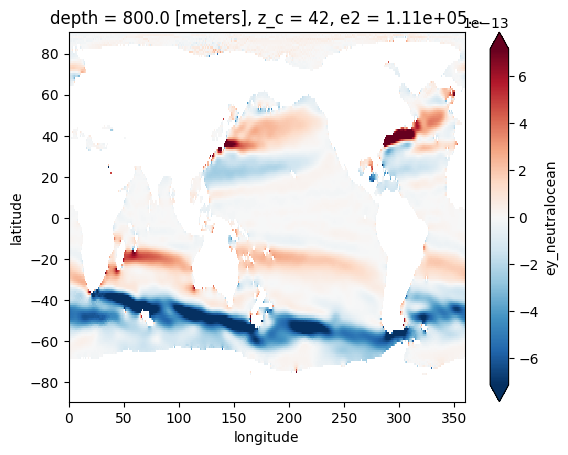

In [9]:
ds.ey_neutralocean.isel(z_c=42).plot(x="lon", y="lat_right", robust=True)

we compute by hand using in situ density

$$
\vec{\epsilon_h} = \vec{\nabla_h} \rho
$$

In [10]:
# if we compute by hand
rho = gsw.rho(
    ds.SA,
    ds.CT,
    ds.p,
)

In [11]:
ds["ey"] = grid.derivative(rho, "Y")
ds["ex"] = grid.derivative(rho, "X")

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


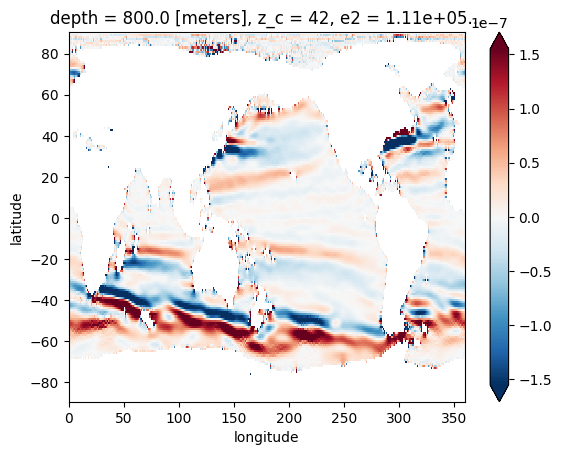

In [12]:
(ds.ey_neutralocean*1e6-ds.ey).isel(z_c=42).plot(x="lon", y="lat_right", robust=True)

## We need to compute N2 at U and V points to get slopes

### What is our ex, ey

As we compute along iso-depth, the gradients along surface are horizontal gradients:

$$
\vec{\epsilon_h} = \vec{\nabla}_h \rho = \rho_S \vec{\nabla}_h S +  \rho_\Theta \vec{\nabla}_h \Theta
$$

$$
\vec{\nabla}_h z = - \frac{1}{\rho_0} \frac{g}{N^2} \vec{\epsilon_h}
$$

We need to compute $\vec{\nabla}_h z$ at U and V points

$$
N^2 = -\frac{g}{\rho_0} \frac{\partial \rho}{\partial z}
$$

$$
N^2 = g \left(\alpha \frac{\partial \Theta}{\partial z} 
- \beta \frac{\partial S_A}{\partial z} \right)
$$

In [13]:
# compute rho and N2
N2_gsw = ds.gsw.Nsquared(axis=-1, lat=None)

In [14]:
ds["N2_gsw"] = (("x_c", "y_c", "z_f"), np.append(N2_gsw[0], np.nan*np.zeros((360,180,1)), axis=-1))

In [15]:
g = 9.7963
# https://teos-10.github.io/GSW-Python/_modules/gsw/stability.html#Nsquared

In [16]:
dCT_dz = -grid.derivative(ds.cf["sea_water_conservative_temperature"], "Z")
# minus sign as z increases downward

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [17]:
dSA_dz = -grid.derivative(ds.cf["sea_water_absolute_salinity"], "Z")
# minus sign as z increases downward

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [18]:
CT_w = grid.interp(ds.cf["sea_water_conservative_temperature"], "Z")
SA_w = grid.interp(ds.cf["sea_water_absolute_salinity"], "Z")

/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [19]:
alpha = gsw.alpha(SA_w, CT_w, gsw.p_from_z(z=-ds.depth_right, lat=ds.lat))
beta = gsw.beta(SA_w, CT_w, gsw.p_from_z(z=-ds.depth_right, lat=ds.lat))

In [20]:
N2 = g * (alpha*dCT_dz - beta*dSA_dz)

In [21]:
N2.isel(z_f=0) - N2_gsw[0][:,:,0]

<xarray.DataArray (x_c: 360, y_c: 180)> Size: 518kB
array([[           nan,            nan,            nan, ...,
        3.05950226e-07, 2.90145398e-07, 4.77872553e-07],
       [           nan,            nan,            nan, ...,
        2.96344402e-07, 2.93203800e-07, 4.77863414e-07],
       [           nan,            nan,            nan, ...,
        2.89811389e-07, 2.86962729e-07, 4.77854275e-07],
       ...,
       [           nan,            nan,            nan, ...,
        3.22478609e-07, 3.07056024e-07, 4.77939283e-07],
       [           nan,            nan,            nan, ...,
        3.14068681e-07, 3.02337236e-07, 4.77914419e-07],
       [           nan,            nan,            nan, ...,
        3.08882515e-07, 2.99496670e-07, 4.77889554e-07]])
Coordinates:
  * y_c          (y_c) int64 1kB 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
  * x_c          (x_c) int64 3kB 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
    z_f          int64 8B 0
    depth_right  float32 4B 2.5
    e2           float32 4B 1.11e+05
    e3w          float32 4B 5.0
    lat          (y_c) float32 720B -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
    e1tu         (y_c) float32 720B 968.6 2.906e+03 ... 2.906e+03 968.6

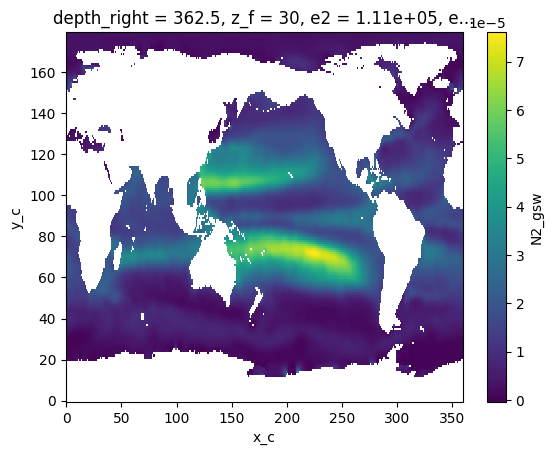

In [22]:
ds.N2_gsw.isel(z_f=30).plot(x="x_c", y="y_c", center=False)

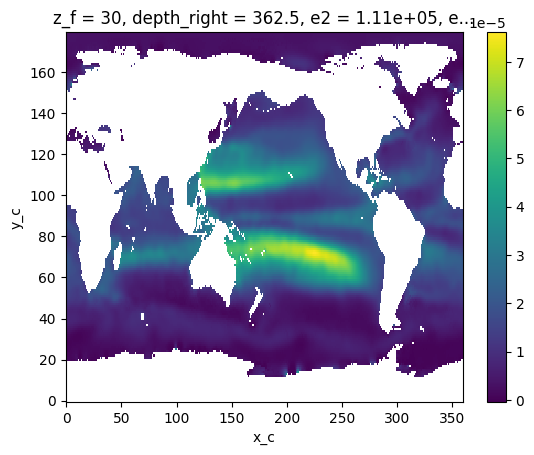

In [23]:
N2.isel(z_f=30).plot(x="x_c", y="y_c", center=False)

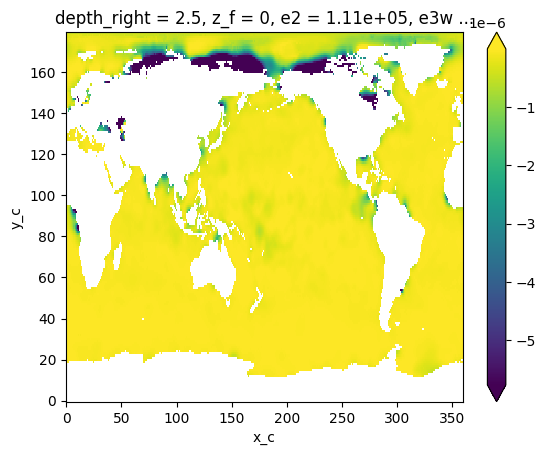

In [24]:
(ds.N2_gsw-N2).isel(z_f=0).plot(x="x_c", y="y_c", center=False, robust=True)

The two calculation of N2 are slightly different, as we computed alpha and beta with a pressure derived with `gsw.p_from_z` that considers a constant density, while the gsw.Nsquarred function works on pressure with the real hydrostatic gradient, ie with $\rho$ and not $\rho_0$

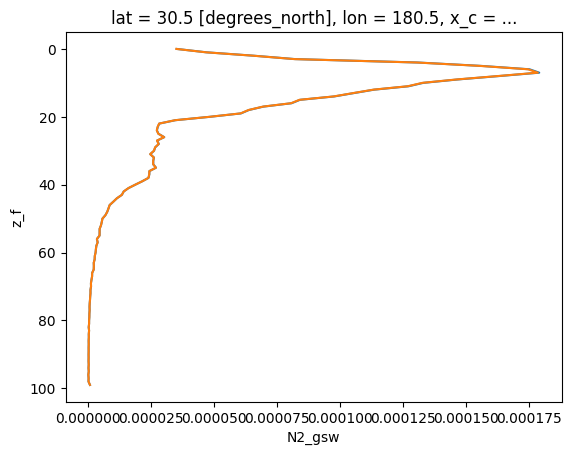

In [25]:
N2.isel(x_c=180, y_c=120).plot(y="z_f", yincrease=False)
ds.N2_gsw.isel(x_c=180, y_c=120).plot(y="z_f", yincrease=False)


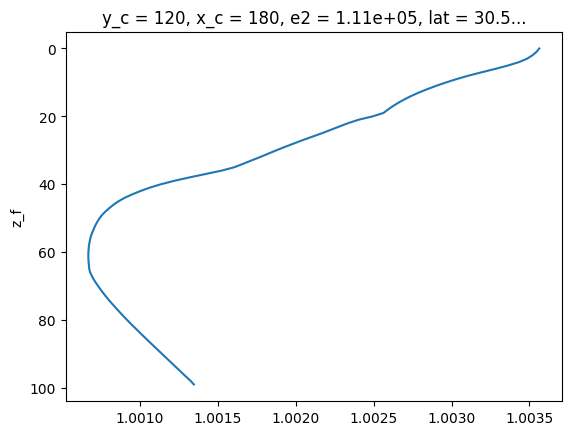

In [26]:
(N2/ds.N2_gsw).isel(x_c=180, y_c=120).plot(y="z_f", yincrease=False)


In [27]:
ds["N2"] = N2

Remember what we want:


$$
\vec{\nabla}_h z = - \frac{1}{\rho_0} \frac{g}{N^2} \vec{\epsilon_h}
$$

So we interpolate $N^2$, $\Theta$, and $S_A$ at U and V point

In [28]:
ds["rho_0"] = 1026

In [29]:
#ds["grad_h_z_U"] = - gsw.rho(
#    grid.interp(ds.cf["sea_water_absolute_salinity"], "X"),
#    grid.interp(ds.cf["sea_water_conservative_temperature"], "X"),
#    ds.p
#) / ds.rho_0 * g / grid.interp(
#    ds.N2,
#    ["X","Z"],
#) * ds.ex


ds["grad_h_z_U"] = - 1 / ds.rho_0 * g / grid.interp(
    ds.N2,
    ["X","Z"],
) * ds.ex


/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [30]:
#ds["grad_h_z_V"] = - gsw.rho(
#    grid.interp(ds.cf["sea_water_absolute_salinity"], "Y"),
#    grid.interp(ds.cf["sea_water_conservative_temperature"], "Y"),
#    gsw.p_from_z(-ds.depth, ds.lat_right)
#) / ds.rho_0 * g / grid.interp(
#    ds.N2,
#    ["Y","Z"],
#) * ds.ey

ds["grad_h_z_V"] = - 1 / ds.rho_0 * g / grid.interp(
    ds.N2,
    ["Y","Z"],
) * ds.ey


/home/romain/.cache/pypoetry/virtualenvs/neutral-density-BeRXjZM7-py3.10/lib/python3.10/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg


In [32]:
ds[[
    "ex", "ey", "grad_h_z_U", "grad_h_z_V", "ey_neutralocean", "ex_neutralocean"
]].to_netcdf("../data/neutral_slopes_woa.nc")